# Dimensionality reduction on trial features

In [1]:
prefix = '/home/ines/repositories/'
# prefix = '/Users/ineslaranjeira/Documents/Repositories/'

In [5]:
""" 
IMPORTS
"""
import os
import numpy as np
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# --Machine learning and statistics

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler,  LabelBinarizer
import umap
from sklearn import mixture
import pickle
from scipy.stats import mode
from sklearn.metrics.pairwise import pairwise_distances
from scipy.cluster.hierarchy import fcluster
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch
from scipy.spatial.distance import cosine
from sklearn.decomposition import PCA
from statsmodels.distributions.empirical_distribution import ECDF
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import itertools

# Get my functions
functions_path =  prefix + 'representation_learning_variability/Models/Sub-trial//2_fit_models/'
os.chdir(functions_path)
from preprocessing_functions import idxs_from_files
functions_path =  prefix + 'representation_learning_variability/Models/Sub-trial/4_analyses/5_clustering_analyses/'
os.chdir(functions_path)
# from clustering_functions import calculate_entropy
functions_path =  prefix + 'representation_learning_variability/Models/Sub-trial//3_postprocess_results/'
os.chdir(functions_path)
from plotting_functions import create_grouped_gradient_palette
from one.api import ONE
one = ONE(mode='remote')

In [3]:
data_path = prefix + 'representation_learning_variability/paper-individuality/fig1_segmentation/'
# states_file = pd.read_parquet(data_path+'states_trial_type_5k_5_09-24-2025')
states_file = pd.read_parquet(data_path+'states_trial_type_11-20-2025')

# filename = str(data_path + 'all_sequences_5k_09-24-2025')
filename = str(data_path + 'all_sequences_11-20-2025')
all_sequences = pd.read_parquet(filename)

# Remap paw states to be simpler

In [6]:
def create_mapping(strings, order):

    strings_sorted = sorted(strings, key=lambda s: tuple(int(s[i]) for i in order))

    identifiable_mapping = {
        s: float(i) for i, s in enumerate(strings_sorted)
    }
    
    return identifiable_mapping


def compress_d2_d3(d2, d3):
    if d2 == "0" and d3 == "0":
        return "0"
    if d2 in ("1", "2") and d3 == "0":
        return "1"
    if d2 == "0" and d3 in ("1", "2"):
        return "2"
    if d2 in ("1", "2") and d3 in ("1", "2"):
        return "3"
    raise ValueError(f"Unexpected values d2={d2}, d3={d3}")

def compress_code_5_to_4(code):
    # code is a 5-character string like "01210"
    d0 = code[0]
    d1 = code[1]
    d2 = code[2]
    d3 = code[3]
    d4 = code[4]
    
    new_d12 = compress_d2_d3(d1, d2)
    
    return f"{d0}{new_d12}{d3}{d4}"


In [7]:
ranges = {
    0: [0,1,2],
    1: [0,1,2],
    2: [0,1,2],
    3: [0,1],
    4: [0,1],
}
# generate all strings
original_strings = [
    f"{d0}{d1}{d2}{d3}{d4}"
    for d0, d1, d2, d3, d4 in itertools.product(
        ranges[0], ranges[1], ranges[2], ranges[3], ranges[4]
    )
]

# custom sort: using order 1,2,3,4,0
order = [1,2,3,4,0]
identifiable_mapping = create_mapping(original_strings, order)
inverted_mapping = {v: k for k, v in identifiable_mapping.items()}

compressed_strings = list(np.unique(pd.Series(original_strings).apply(compress_code_5_to_4)))
order = [1,2,3,0]
comp_identifiable_mapping = create_mapping(compressed_strings, order)
inverted_comp_mapping = {v: k for k, v in comp_identifiable_mapping.items()}

In [4]:
# states_file = states_file.loc[states_file['mouse_name'].isin(mice_to_keep)]
# all_sequences = all_sequences.loc[all_sequences['mouse_name'].isin(mice_to_keep)]

In [8]:
## Get sequences per trial epoch

design_df = all_sequences.pivot(index=['sample', 'trial_type', 'mouse_name'], columns=['broader_label'], values='binned_sequence').reset_index().dropna()
var_names = design_df.keys()[-4:]
df = design_df.copy()
df['feedback'] = df['trial_type'].str.split().str[:1].str.join('')
df['choice'] = df['trial_type'].str.split().str[3:4].str.join('')
df['block'] = df['trial_type'].str.split().str[2:3].str.join('')
df['contrast'] = df['trial_type'].str.split().str[1:2].str.join('')
df['side'] = df['choice'].copy()
df.loc[(df['feedback']=='correct') & (df['choice']=='right'), 'side'] = 'left'
df.loc[(df['feedback']=='correct') & (df['choice']=='left'), 'side'] = 'right'

df['session'] = df['sample'].str.split().str[:1].str.join('')
df['trial_id'] = df['sample'].str.split().str[1:2].str.join('')
## Get timing data


# Get timing info
vars = ['trial_id', 'session', 'mouse_name']

elongation = pd.DataFrame(states_file.groupby(vars)['elongation'].mean()).reset_index()
elongation['trial_id'] = elongation['trial_id'].astype(str)
response = pd.DataFrame(states_file.groupby(vars)['response'].mean()).reset_index()
response['trial_id'] = response['trial_id'].astype(str)
reaction = pd.DataFrame(states_file.groupby(vars)['reaction'].mean()).reset_index()
reaction['trial_id'] = reaction['trial_id'].astype(str)

# Merge

merged_df = df.merge(elongation, on=['session', 'trial_id', 'mouse_name'])
merged_df = merged_df.merge(response, on=['session', 'trial_id', 'mouse_name'])
merged_df = merged_df.merge(reaction, on=['session', 'trial_id', 'mouse_name'])

merged_df['contrast'] = merged_df['contrast'].astype(float)
merged_df['block'] = merged_df['block'].astype(float)

# Timing quantiles and choice
merged_df['response_qt'] = pd.qcut(merged_df['response'], 4, labels=False)/4
merged_df['elongation_qt'] = pd.qcut(merged_df['elongation'], 4, labels=False)/4

merged_df['choice'] = merged_df['trial_type'].str.split().str[3:4].str.join('')
merged_df.loc[merged_df['choice']=='left', 'choice'] = 0
merged_df.loc[merged_df['choice']=='right', 'choice'] = 1

merged_df.loc[merged_df['feedback']=='correct', 'feedback'] = 1
merged_df.loc[merged_df['feedback']=='incorrect', 'feedback'] = 0
del states_file

## Get sequences per trial

In [9]:
all_sequences['session'] = all_sequences['sample'].str[:36]

In [10]:
design_df = all_sequences.pivot(index=['sample', 'trial_type', 'mouse_name', 'session'], columns=['broader_label'], values='binned_sequence').reset_index().dropna()
var_names = design_df.keys()[-4:]

## Separate states per variable (one-hot encoding)

In [11]:
epoch_to_analyse = ['Pre-quiescence', 'Quiescence', 'Choice', 'ITI']

sequences_choice = np.vstack(design_df[epoch_to_analyse].apply(lambda row: np.hstack(row), axis=1))  # Transpose to get the right shape
use_sequences = sequences_choice[~np.isnan(sequences_choice).any(axis=1)]


# Integer to string
replace_func = np.vectorize(inverted_mapping.get)
string_form = replace_func(use_sequences)
# String compression
vectorized_compress = np.vectorize(compress_code_5_to_4)
compressed_codes = vectorized_compress(string_form)
# String to integer
replace_func = np.vectorize(comp_identifiable_mapping.get)
use_sequences = replace_func(compressed_codes)



use_states = int(max(np.unique(use_sequences)))+1
timesteps = np.shape(use_sequences)[1]
binarized = np.zeros((np.shape(use_sequences)[0], timesteps*use_states))

for t in range(timesteps):
    label_binarizer = LabelBinarizer()
    label_binarizer.fit(range(use_states))
    encoded_arr = label_binarizer.transform(use_sequences[:, t])
    binarized[:, t*use_states:(t+1)*use_states] = encoded_arr

## Average per session

In [12]:
session_syllables = pd.DataFrame(binarized)
session_syllables['session'] = design_df['session'].copy()
session_syllables['mouse_name'] = design_df['mouse_name'].copy()
# session_syllables = session_syllables.groupby(['session', 'mouse_name'])[np.arange(0, np.shape(final_matrix)[1], 1)].mean()

session_syllables = session_syllables.groupby(['session'])[np.arange(0, np.shape(binarized)[1], 1)].mean()

([<matplotlib.axis.XTick at 0x74339c451720>,
 [Text(0, 0, '0'),
  Text(160, 0, '160'),
  Text(320, 0, '320'),
  Text(480, 0, '480'),
  Text(640, 0, '640'),
  Text(800, 0, '800'),
  Text(960, 0, '960'),
  Text(1120, 0, '1120'),
  Text(1280, 0, '1280'),
  Text(1440, 0, '1440'),
  Text(1600, 0, '1600'),
  Text(1760, 0, '1760'),
  Text(1920, 0, '1920'),
  Text(2080, 0, '2080'),
  Text(2240, 0, '2240'),
  Text(2400, 0, '2400'),
  Text(2560, 0, '2560'),
  Text(2720, 0, '2720'),
  Text(2880, 0, '2880'),
  Text(3040, 0, '3040'),
  Text(3200, 0, '3200'),
  Text(3360, 0, '3360'),
  Text(3520, 0, '3520'),
  Text(3680, 0, '3680'),
  Text(3840, 0, '3840'),
  Text(4000, 0, '4000'),
  Text(4160, 0, '4160')])

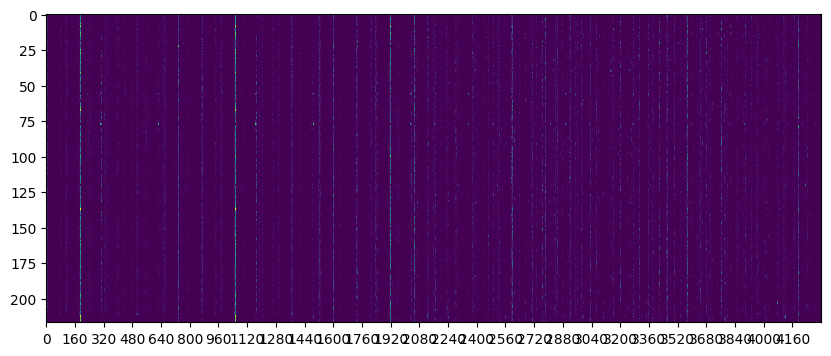

In [14]:
plt.figure(figsize=(10, 4))
plt.imshow(np.array(session_syllables), aspect='auto', cmap='viridis', interpolation='none')
plt.xticks(np.arange(0, np.shape(binarized)[1], 160), np.arange(0, np.shape(binarized)[1], 160))

In [14]:
final_matrix = np.array(session_syllables)

# PCA

In [15]:
n_components = 200
# Step 1: Reduce dimensions with PCA
pca = PCA(n_components)  # Reduce to 50 dimensions
scaler = StandardScaler()
standardized_X = scaler.fit_transform(final_matrix)
# X_pca = pca.fit_transform(standardized_X)
X_pca = pca.fit_transform(final_matrix)


Text(0.5, 1.0, 'Explained Variance by PCA')

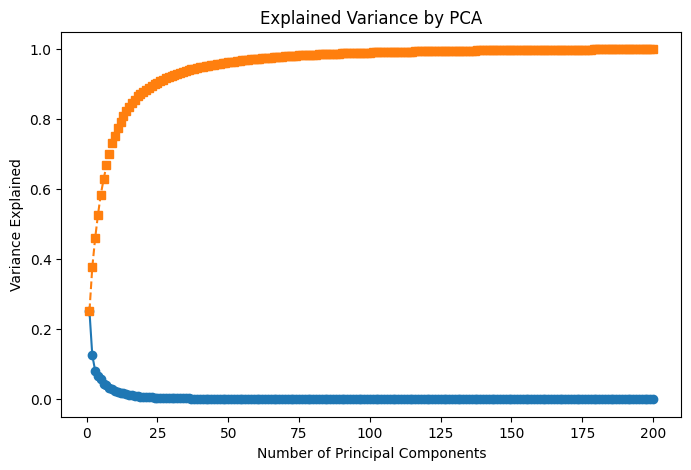

In [16]:
# Explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)

# Plot explained variance
plt.figure(figsize=(8, 5))
plt.plot(range(1, n_components+1), explained_variance_ratio, marker='o', label='Individual')
plt.plot(range(1, n_components+1), cumulative_variance, marker='s', label='Cumulative', linestyle='--')
plt.xlabel("Number of Principal Components")
plt.ylabel("Variance Explained")
plt.title("Explained Variance by PCA")

In [23]:
def split_sessions(all_sequences, n_parts):

    rng = np.random.default_rng() 
    all_sequences['session_part'] = np.zeros(len(all_sequences))
    for s, session in enumerate(all_sequences.session.unique()):
        session_df = all_sequences.loc[all_sequences['session']==session]
        n_trials = len(session_df)
        # Create shuffled labels for parts
        parts = np.tile(np.arange(n_parts), int(np.ceil(n_trials / n_parts)))[:n_trials]
        rng.shuffle(parts)  # Shuffle to randomize assignment
        # els.extend(parts)
        all_sequences.loc[all_sequences['session']==session, 'session_part'] = parts
    # Assign to new column
    all_sequences['session_part'] = all_sequences['session_part'].astype(str)
    # all_sequences = all_sequences.rename(columns={"sample": "trial_id"})
    all_sequences['session_part_sample'] = all_sequences[['session', 'session_part']].agg(' '.join, axis=1)
    split_session_df = all_sequences.copy()
    return split_session_df



def get_fraction_vectors(trial_clusters, target_length):

    all_sequences = pd.DataFrame(columns=['sample', 'mouse_name', 'session', 'trial_type', 'cluster', 'bin'])
    for s, sample in enumerate(trial_clusters['sample'].unique()):

        # Get session data and order trials
        session_data = trial_clusters.loc[trial_clusters['sample']==sample]
        session_data = session_data[['sample', 'mouse_name', 'session', 'trial_id', 'trial_type', 'cluster']].drop_duplicates()
        session_data['trial_id'] = session_data['trial_id'].astype(float)
        session_data = session_data.sort_values(by=['trial_id'])

        # Bin 
        n_trials = len(session_data)
        # Assign bin index: split into 10 parts
        bin_indices = pd.qcut(np.arange(n_trials), q=target_length, labels=False)
        session_data['bin'] = bin_indices
        
        all_sequences = pd.concat([all_sequences, session_data[['sample', 'mouse_name', 'session', 
                                                                'trial_type', 'cluster', 'bin']]], ignore_index=True)

    fractions = all_sequences.groupby(['sample', 'mouse_name', 'session',
                                    'bin'])['cluster'].value_counts(normalize=True).rename('fraction').reset_index().sort_values(by=['bin', 'cluster'])
    design_df = fractions.pivot(index=['mouse_name', 'sample', 'session'], columns=['bin', 'cluster'], values='fraction').reset_index().fillna(0)

    return design_df


def binarize(design_df, remap):

    epoch_to_analyse = ['Pre-quiescence', 'Quiescence', 'Choice', 'ITI']
    sequences_choice = np.vstack(design_df[epoch_to_analyse].apply(lambda row: np.hstack(row), axis=1))  # Transpose to get the right shape
    use_sequences = sequences_choice[~np.isnan(sequences_choice).any(axis=1)]
    if remap:
        # use_sequences = replace_func(use_sequences)
        # Integer to string
        replace_func = np.vectorize(inverted_mapping.get)
        string_form = replace_func(use_sequences)
        # String compression
        vectorized_compress = np.vectorize(compress_code_5_to_4)
        compressed_codes = vectorized_compress(string_form)
        # String to integer
        replace_func = np.vectorize(comp_identifiable_mapping.get)
        use_sequences = replace_func(compressed_codes)

    use_states = int(max(np.unique(use_sequences)))+1
    timesteps = np.shape(use_sequences)[1]
    binarized = np.zeros((np.shape(use_sequences)[0], timesteps*use_states))

    for t in range(timesteps):
        label_binarizer = LabelBinarizer()
        label_binarizer.fit(range(use_states))
        encoded_arr = label_binarizer.transform(use_sequences[:, t])
        binarized[:, t*use_states:(t+1)*use_states] = encoded_arr

    return binarized


def prepare_design_mat(design_df):
    decoded_var = 'mouse_name'
    var = 'fact_var'

    mat = pd.DataFrame(design_df)
    mat['fact_var'] = pd.factorize(design_df[decoded_var])[0]
    mat[decoded_var] = design_df[decoded_var]

    use_labels = mat['fact_var'].unique()

    session_mouse_names = mat.loc[mat['fact_var'].isin(use_labels), decoded_var]
    session_names = pd.factorize(design_df['session'])[0]
    named_labels = mat.loc[mat['fact_var'].isin(use_labels), decoded_var].drop_duplicates()
    use_mat_pre = mat.loc[mat['fact_var'].isin(use_labels)]
    # array_mat = np.array(use_mat_pre.drop(columns=[decoded_var, 'sample', 'session']))
    array_mat = np.array(use_mat_pre.drop(columns=[decoded_var, 'session']))

    use_mat = pd.DataFrame(array_mat[:, :-1])
    use_mat[var] = use_mat_pre[var]
    
    return use_mat, named_labels, session_mouse_names, session_names 

## Repeated samplings

In [18]:
n_components = 200
# n_components = 100

keep_components = 50
n_parts = 2
repeats = 100

In [24]:
samplings_df = pd.DataFrame(columns=['repeat', 'matrix', 'distance_matrix'], index=range(repeats))

for r in range(repeats):
    print('Repeat %d of %d' % (r+1, repeats))  
        
    # Split data anew
    split_session_df = split_sessions(design_df, 2)
    split_session_df = split_session_df.sort_values(by=['mouse_name', 'session'])
    split_session_df = split_session_df.loc[split_session_df['session_part']=='0.0']  # Use only one sample per session each time
    use_samples = split_session_df['sample']
    use_sequences = all_sequences.loc[all_sequences['sample'].isin(np.array(use_samples))]
    
    use_df = use_sequences.pivot(index=['sample', 'trial_type', 'mouse_name', 'session'], 
                                 columns=['broader_label'], values='binned_sequence').reset_index().dropna()    
    use_df = use_sequences.pivot(index=['sample', 'mouse_name', 'session'], 
                                 columns=['broader_label'], values='binned_sequence').reset_index().dropna()
    var_names = use_df.keys()[-4:]
        
    use_binarized = binarize(use_df, remap=True)
    pca = PCA(n_components)  # Reduce to 50 dimensions
    X_pca = pca.fit(final_matrix).transform(use_binarized)
    session_syllables = pd.DataFrame(X_pca[:, :keep_components])
    session_syllables['session'] = use_df['session'].copy()
    session_syllables['mouse_name'] = use_df['mouse_name'].copy()
    # session_syllables = session_syllables.groupby(['session', 'mouse_name'])[np.arange(0, np.shape(final_matrix)[1], 1)].mean().reset_index()
    session_syllables = session_syllables.groupby(['session', 'mouse_name'])[np.arange(0, keep_components, 1)].mean().reset_index()
    session_syllables = session_syllables.sort_values(by=['mouse_name', 'session'])

    use_mat, named_labels, session_mouse_names, session_names = prepare_design_mat(session_syllables)
    pairwise_matrix = pairwise_distances(use_mat.drop(columns='fact_var'), metric='cosine')

    # Save results
    samplings_df.loc[r, 'repeat'] = r
    samplings_df.loc[r, 'matrix'] = np.array(use_mat.drop(columns='fact_var'))
    samplings_df.loc[r, 'distance_matrix'] = pairwise_matrix

Repeat 1 of 100
Repeat 2 of 100
Repeat 3 of 100
Repeat 4 of 100
Repeat 5 of 100
Repeat 6 of 100
Repeat 7 of 100
Repeat 8 of 100
Repeat 9 of 100
Repeat 10 of 100
Repeat 11 of 100
Repeat 12 of 100
Repeat 13 of 100
Repeat 14 of 100
Repeat 15 of 100
Repeat 16 of 100
Repeat 17 of 100
Repeat 18 of 100
Repeat 19 of 100
Repeat 20 of 100
Repeat 21 of 100
Repeat 22 of 100
Repeat 23 of 100
Repeat 24 of 100
Repeat 25 of 100
Repeat 26 of 100
Repeat 27 of 100


KeyboardInterrupt: 

In [25]:
np.shape(samplings_df['distance_matrix'][0])[0]

218

/tmp/ipykernel_23907/1762714770.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  orig_map=plt.cm.get_cmap('Greys')


(0.0, 218.0)

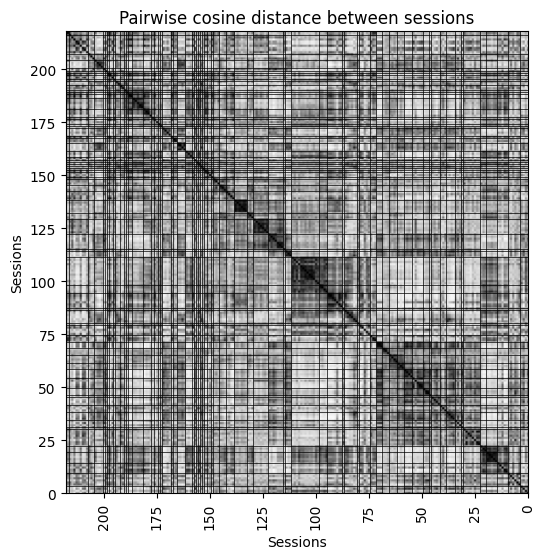

In [24]:
palette=sns.color_palette('Greys', as_cmap=True)
orig_map=plt.cm.get_cmap('Greys')
# reversing the original colormap using reversed() function
reversed_map = orig_map.reversed()

fig, ax = plt.subplots(figsize=[10, 6])
plt.imshow(np.mean(list(samplings_df['distance_matrix']), axis=0), cmap=reversed_map)
plt.xlabel('Sessions')
plt.ylabel('Sessions')
plt.title('Pairwise cosine distance between sessions')

mouse_numbers = pd.factorize(session_syllables['mouse_name'])[0]
# mouse_numbers = session_mouse_names
for m_lines in np.where(np.diff(mouse_numbers)==1):
    plt.vlines(m_lines+.5, 0, len(mouse_numbers), color='k', linewidth=0.5)
    plt.hlines(m_lines+.5, 0, len(mouse_numbers), color='k', linewidth=0.5)
plt.xticks(rotation = 90)
plt.yticks(rotation = 0)

plt.xlim([np.shape(samplings_df['distance_matrix'][0])[0], 0])
plt.ylim([0, np.shape(samplings_df['distance_matrix'][0])[0]])

## Cluster each repeat and build consensus matrix

In [30]:
palette = sns.color_palette("Greys", 10)


/tmp/ipykernel_11301/630746521.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  samplings_df['k'] = samplings_df['repeat'] * np.nan
/tmp/ipykernel_11301/630746521.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  samplings_df['clusters'] = samplings_df['repeat'] * np.nan
/tmp/ipykernel_11301/630746521.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pa

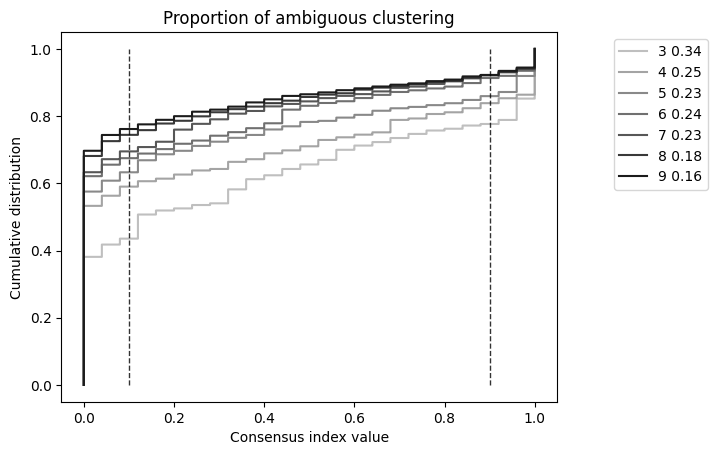

In [34]:
K = [3, 4, 5, 6, 7, 8, 9, 10]
K = [3, 4, 5, 6, 7, 8, 9]
# K = [5, 6, 7, 8, 9, 10, 11]
all_ks = pd.DataFrame()

samplings_df['k'] = samplings_df['repeat'] * np.nan
samplings_df['clusters'] = samplings_df['repeat'] * np.nan

for kk, k in enumerate(K):
    
    samplings_df['k'] = k
    samplings_df['clusters'] = samplings_df['repeat'] * np.nan
    n_samples, _ = pairwise_matrix.shape
    consensus_matrix = np.zeros((n_samples, n_samples))

    for r in range(repeats):
        pairwise_matrix = list(samplings_df.loc[samplings_df['repeat']==r, 'distance_matrix'])[0]
        # linkage_matrix = sch.linkage(pairwise_matrix, method='average', metric='cosine')
        linkage_matrix = sch.linkage(pairwise_matrix, method='average', metric='cosine')
        # _ = plot_dendrogram(pairwise_matrix, title="Hierarchical Clustering")
        # plt.show()
        
        clusters = fcluster(linkage_matrix, t=k, criterion='maxclust')
        samplings_df['clusters'][r] = clusters 

        for i in range(n_samples):
            for j in range(i, n_samples):
                if clusters[i] == clusters[j]:
                    consensus_matrix[i, j] += 1
                    if i != j:
                        consensus_matrix[j, i] += 1  # symmetry
                            
    # Normalize to [0, 1]
    consensus_matrix /= repeats

    # Save
    if i == 0:
        all_ks = samplings_df
    else:
        all_ks = pd.concat([all_ks, samplings_df]) 

    # e = ECDF(consensus_matrix)
    e = ECDF(np.ravel(consensus_matrix))
    low_index = np.where(e.x>.1)[0][0]
    high_index = np.where(e.x<0.9)[0][-1]
    # low_index = np.where(e.x>.2)[0][0]
    # high_index = np.where(e.x<0.8)[0][-1]
    PAC = e.y[high_index] - e.y[low_index]
    # plt.step(e.x[1::10], e.y[1::10], label=str(str(k)+' '+str(np.round(PAC, 2))), color=palette[kk+3])
    plt.step(e.x, e.y, label=str(str(k)+' '+str(np.round(PAC, 2))), color=palette[kk+3]) # ,
plt.vlines(0.1, 0, 1, linestyle='dashed', color='black', alpha=.8, linewidth=1)
plt.vlines(0.9, 0, 1, linestyle='dashed', color='black', alpha=.8, linewidth=1)
plt.legend(loc='upper left', bbox_to_anchor=(1.1, 1))
plt.xlabel('Consensus index value')
plt.ylabel('Cumulative distribution')
plt.title('Proportion of ambiguous clustering')
plt.show()

# Run with final k

In [35]:
k = 5
samplings_df['k'] = k
samplings_df['clusters'] = samplings_df['repeat'] * np.nan
n_samples, _ = pairwise_matrix.shape
consensus_matrix = np.zeros((n_samples, n_samples))

for r in range(repeats):
    pairwise_matrix = list(samplings_df.loc[samplings_df['repeat']==r, 'distance_matrix'])[0]
    linkage_matrix = sch.linkage(pairwise_matrix, method='average', metric='cosine')
    # _ = plot_dendrogram(pairwise_matrix, title="Hierarchical Clustering")
    # plt.show()

    clusters = fcluster(linkage_matrix, t=k, criterion='maxclust')
    samplings_df['clusters'][r] = clusters 

    for i in range(n_samples):
        for j in range(i, n_samples):
            if clusters[i] == clusters[j]:
                consensus_matrix[i, j] += 1
                if i != j:
                    consensus_matrix[j, i] += 1  # symmetry
                        
# Normalize to [0, 1]
consensus_matrix /= repeats

/tmp/ipykernel_11301/3745642709.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  samplings_df['k'] = k
/tmp/ipykernel_11301/3745642709.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  samplings_df['clusters'] = samplings_df['repeat'] * np.nan
/tmp/ipykernel_11301/3745642709.py:9: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage_matrix = sch.linkage(pairwise_matrix, method='average', metric='cosine')
/tmp/ipykernel_113

(array([-50.,   0.,  50., 100., 150., 200., 250.]),
 [Text(0, -50.0, '−50'),
  Text(0, 0.0, '0'),
  Text(0, 50.0, '50'),
  Text(0, 100.0, '100'),
  Text(0, 150.0, '150'),
  Text(0, 200.0, '200'),
  Text(0, 250.0, '250')])

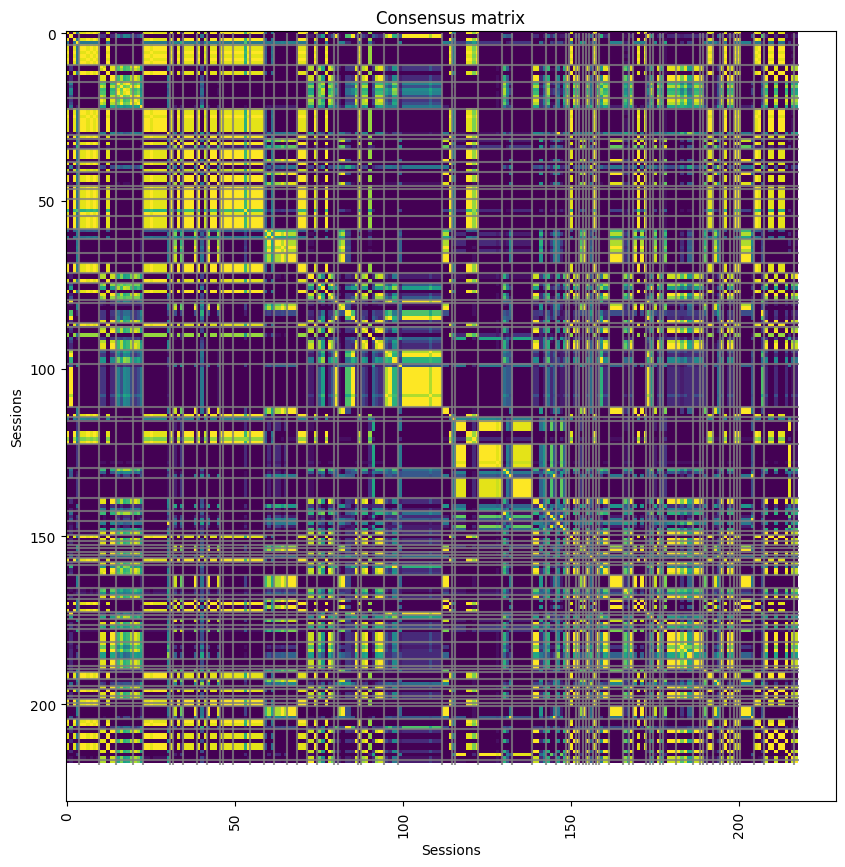

In [36]:
fig, ax = plt.subplots(figsize=[12, 10])
plt.imshow(consensus_matrix)
plt.xlabel('Sessions')
plt.ylabel('Sessions')
plt.title('Consensus matrix')

mouse_numbers = pd.factorize(session_syllables['mouse_name'])[0]
# mouse_numbers = session_mouse_names
for m_lines in np.where(np.diff(mouse_numbers)==1):
    plt.vlines(m_lines+.5, 0, len(mouse_numbers), color='grey', alpha=.8)
    plt.hlines(m_lines+.5, 0, len(mouse_numbers), color='grey', alpha=.8)
plt.xticks(rotation = 90)
plt.yticks(rotation = 0)


In [37]:
# Associate clusters with unsplit data; attention to sorting!!
use_sequences = all_sequences.copy()
use_df = use_sequences.pivot(index=['sample', 'trial_type', 'mouse_name', 'session'], columns=['broader_label'], values='binned_sequence').reset_index().dropna()
use_df = use_sequences.pivot(index=['sample', 'mouse_name', 'session'], columns=['broader_label'], values='binned_sequence').reset_index().dropna()
var_names = use_df.keys()[-4:]
    
use_binarized = binarize(use_df, remap=False)
full_session_syllables = pd.DataFrame(use_binarized)
full_session_syllables['session'] = np.array(use_df['session'])
full_session_syllables['mouse_name'] = np.array(use_df['mouse_name'])
full_session_syllables = full_session_syllables.groupby(['session', 'mouse_name'])[np.arange(0, np.shape(binarized)[1], 1)].mean().reset_index()
full_session_syllables = full_session_syllables.sort_values(by=['mouse_name', 'session'])

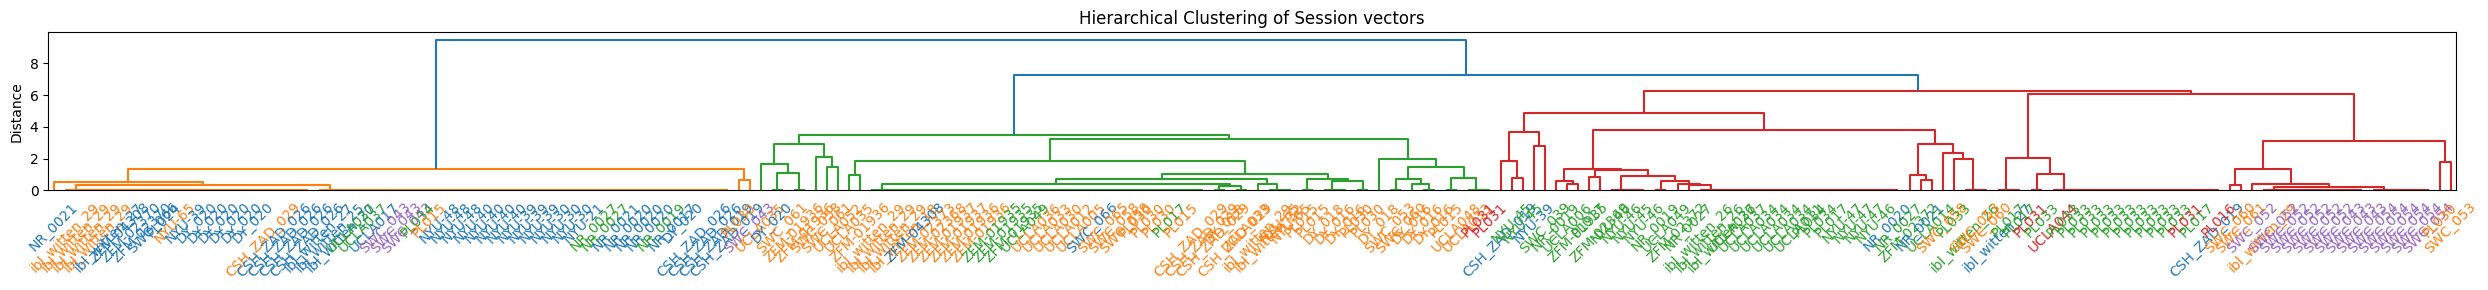

In [38]:
from scipy.cluster.hierarchy import linkage, dendrogram
# Perform clustering
Z = linkage(consensus_matrix.copy(), method='average')  #, metric='cosine')  # You can also try 'complete', 'ward', etc.

from scipy.cluster.hierarchy import ward, fcluster
# final_clusters = fcluster(Z, t=k, criterion='maxclust')
final_clusters = fcluster(Z, t=k, criterion='maxclust')
final_clusters = final_clusters - 1

mouse_labels = np.array(full_session_syllables['mouse_name'])#.unique()
# design_df['session_cluster'] = clusters 

# Plot dendrogram
fig, ax = plt.subplots(figsize=(25, 3))

# Define colors for clusters
cmap = plt.get_cmap(sns.color_palette("tab10", k, as_cmap=True))
# cmap = plt.get_cmap(sns.color_palette(k, as_cmap=True))
colors = [cmap(i % cmap.N) for i in range(k)]
cluster_colors = {i: colors[i] for i in range(k)}

# Plot dendrogram with colored labels
dendro = dendrogram(Z, labels=mouse_labels, leaf_font_size=10, ax=ax, leaf_rotation=45)

# Apply colors to tick labels
x_labels = ax.get_xmajorticklabels()
counter = 0
for lbl in x_labels:
    mouse_id = lbl.get_text()
    cluster_id = final_clusters[mouse_labels==mouse_id][0]
    lbl.set_color(cluster_colors[cluster_id])

plt.title("Hierarchical Clustering of Session vectors")
plt.ylabel("Distance")
plt.tight_layout()

plt.show()

(array([64.,  0., 67.,  0.,  0., 45.,  0., 21.,  0., 21.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <BarContainer object of 10 artists>)

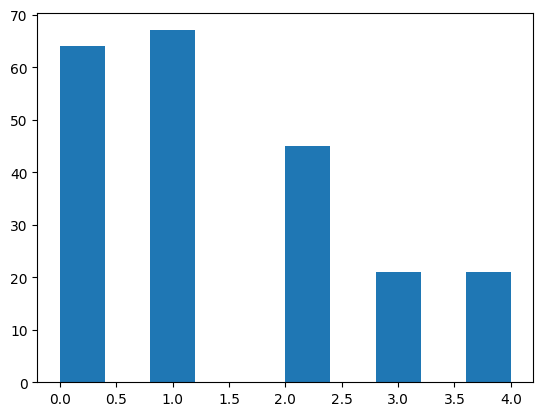

In [39]:
plt.hist(final_clusters)

In [40]:
full_session_syllables['session_cluster'] = final_clusters.copy()

## Save

In [41]:
data_path = prefix + 'representation_learning_variability/paper-individuality/fig4_clustering/'
filename = "5_cluster_per_session_11-20-2025"
full_session_syllables.to_parquet(data_path+filename)  

/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/pandas/io/parquet.py:191: UserWarning: The DataFrame has column names of mixed type. They will be converted to strings and not roundtrip correctly.
  table = self.api.Table.from_pandas(df, **from_pandas_kwargs)


# PCA

In [42]:
n_components = 200
use_data = np.mean(list(samplings_df['distance_matrix']), axis=0).copy()
# use_data = consensus_matrix.copy()
# Step 1: Reduce dimensions with PCA
pca = PCA(n_components)  # Reduce to 50 dimensions
scaler = StandardScaler()
# standardized_X = scaler.fit_transform(use_data)
# X_pca = pca.fit_transform(standardized_X)
X_pca = pca.fit_transform(use_data)


Text(0.5, 1.0, 'Explained Variance by PCA')

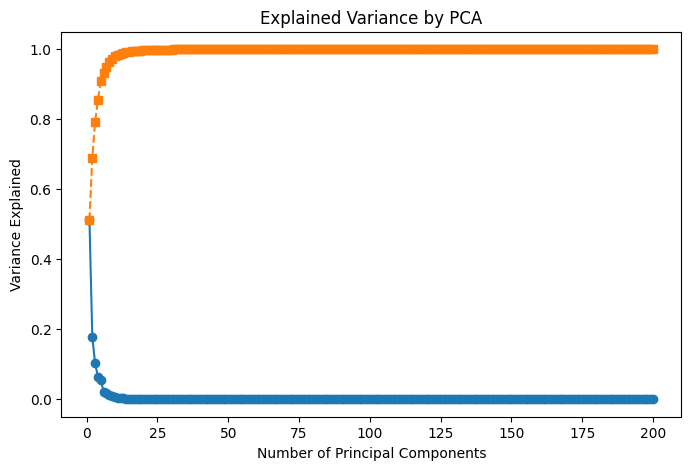

In [43]:
# Explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)

# Plot explained variance
plt.figure(figsize=(8, 5))
plt.plot(range(1, n_components+1), explained_variance_ratio, marker='o', label='Individual')
plt.plot(range(1, n_components+1), cumulative_variance, marker='s', label='Cumulative', linestyle='--')
plt.xlabel("Number of Principal Components")
plt.ylabel("Variance Explained")
plt.title("Explained Variance by PCA")

Text(0, 0.5, 'PC 2')

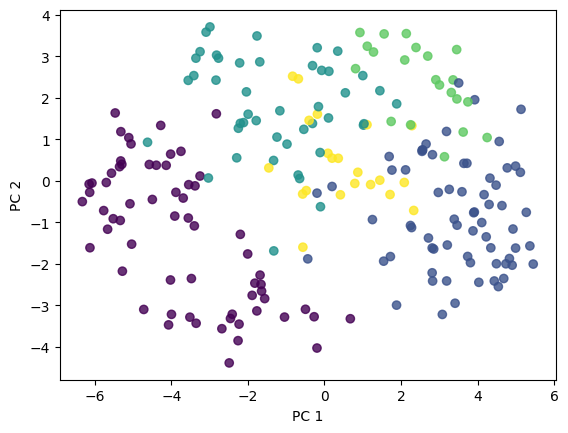

In [44]:
plt.scatter(X_pca[:, 0], X_pca[:, 1], alpha=.8, c=final_clusters)
plt.xlabel('PC 1')
plt.ylabel('PC 2')

In [45]:
import plotly.graph_objects as go

# Create trace, sizing bubbles by planet diameter
fig = go.Figure(data=go.Scatter3d(
    x = X_pca[:, 0],
    y = X_pca[:, 1],
    z = X_pca[:, 3],
    mode = 'markers',
    marker = dict(
        color = final_clusters,
        )
))
fig.show()

## UMAP

In [1]:
reducer = umap.UMAP(random_state= 42, n_components=3)

# Standardization using StandardScaler
# scaler = StandardScaler()
# standardized_X = scaler.fit_transform(ori_X)

mouse_embedding = reducer.fit_transform(use_data)
mouse_embedding.shape


NameError: name 'umap' is not defined

In [ ]:
import plotly.graph_objects as go

# Create trace, sizing bubbles by planet diameter
fig = go.Figure(data=go.Scatter3d(
    x = mouse_embedding[:, 0],
    y = mouse_embedding[:, 1],
    z = mouse_embedding[:, 2],
    mode = 'markers',
    marker = dict(
        color = final_clusters
        
        )
))
fig.show()

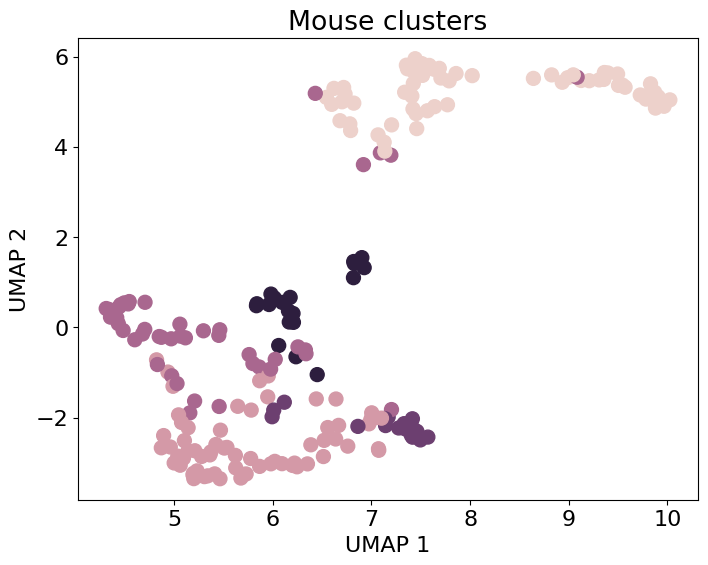

In [ ]:
# Step 2: Perform KMeans Clustering
data_2d = mouse_embedding
# kmeans = KMeans(n_clusters=5, random_state=2024)
# kmeans.fit(data_2d)
# mouse_y_kmeans = kmeans.predict(data_2d)
plt.rcParams.update({'font.size': 16})

# Step 3: Plot the clusters
fig, ax = plt.subplots(figsize=(8, 6))

# Plot each cluster with a different color
scatter = ax.scatter(data_2d[:, 0], data_2d[:, 1], c=final_clusters, s=100, alpha=1, cmap=sns.cubehelix_palette(as_cmap=True))#, edgecolor='black',  cmap=sns.cubehelix_palette(as_cmap=True))


# centroids = kmeans.cluster_centers_
# for c, cent in enumerate(centroids):
#     dots = ax.text(centroids[c, 0], centroids[c, 1], str(c), c='black', alpha=0.7, fontsize=18, weight='bold')

plt.title("Mouse clusters")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
# plt.savefig(file_path+'umap_mice.svg', format="svg")

plt.show()

## Crossing with other behavioral variables

In [67]:
data_path = prefix + 'representation_learning_variability/DATA/'
# data_path =  '/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/DATA/'
learning_df = pd.read_csv(data_path+'learning_private_one.csv')
learning_times = learning_df[['subject_nickname', 'training_time']].drop_duplicates()
learning_times = learning_times.rename(columns={"subject_nickname": "mouse_name"}).reset_index()

data_path =  prefix + 'representation_learning_variability/DATA/'
learning_df = pd.read_parquet(data_path+'training_time_03-21-2025', engine='pyarrow')
learning_times_new = learning_df.rename(columns={"subject_nickname": "mouse_name"}).reset_index()

# new_df = design_df.droplevel(1, axis=1)[['mouse_name', 'session']]
# df = new_df.merge(learning_times, on='mouse_name')
a = learning_times.merge(learning_times_new, on='mouse_name', how='outer')
b = a.loc[a['training_time_x'].isna()]
b = b.rename(columns={"training_time_y": "training_time"}).reset_index()
full_learning = pd.concat([learning_times[['mouse_name', 'training_time']], b[['mouse_name', 'training_time']]]).reset_index()

/tmp/ipykernel_50315/3417959114.py:3: DtypeWarning:

Columns (23) have mixed types. Specify dtype option on import or set low_memory=False.



In [195]:
# mouse_names = df['mouse_name'].copy().drop_duplicates().reset_index()
# mouse_names['cluster'] = final_clusters.copy()
pca_df = pd.DataFrame(X_pca)
# pca_df = pd.DataFrame(data_2d)
pca_df['mouse_name'] = full_session_syllables['mouse_name']
pca_df['session'] = full_session_syllables['session']

var = 'choice'
grouped = merged_df.groupby(['mouse_name', 'session'])[var].mean().reset_index()
merged = pca_df.merge(grouped, on=['mouse_name', 'session'])
merged = merged.merge(full_learning[['mouse_name', 'training_time']], on=['mouse_name'])

NameError: name 'merged_df' is not defined

In [215]:
# mouse_names = df['mouse_name'].copy().drop_duplicates().reset_index()
# mouse_names['cluster'] = final_clusters.copy()
pca_df = pd.DataFrame(X_pca)
# pca_df = pd.DataFrame(data_2d)
pca_df['mouse_name'] = full_session_syllables['mouse_name']
pca_df['session'] = full_session_syllables['session']

# grouped = merged_df.groupby(['mouse_name', 'session'])[var].mean().reset_index()
# merged = pca_df.merge(grouped, on=['mouse_name', 'session'])
merged = pca_df.merge(full_learning[['mouse_name', 'training_time']], on=['mouse_name'])

In [216]:
pc = 3

In [217]:
merged = merged.groupby(['mouse_name', 'session', 'training_time'])[pc].mean().reset_index().dropna()
var = 'training_time'

PearsonRResult(statistic=np.float64(0.06774627811576142), pvalue=np.float64(0.333275447125981))


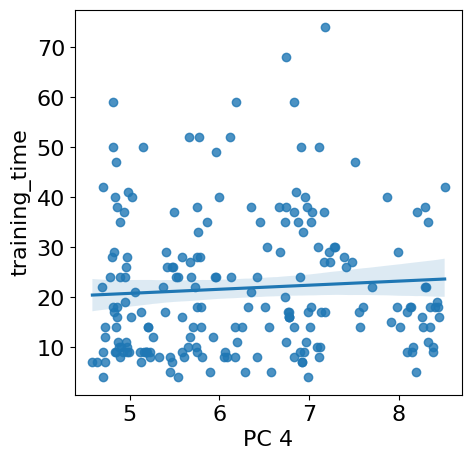

In [218]:
plt.figure(figsize=(5, 5))
sns.regplot(x=np.array(merged[pc]).astype(float), y=merged[var].astype(float), ci=95) 
plt.xlabel('PC '+str(pc+1))
# plt.ylabel('Training time (sessions)')
plt.ylabel(str(var))

from scipy.stats import spearmanr, pearsonr

res = pearsonr(np.array(merged[pc]).astype(float), np.array(merged[var]).astype(float))
print(res)

## Visualize

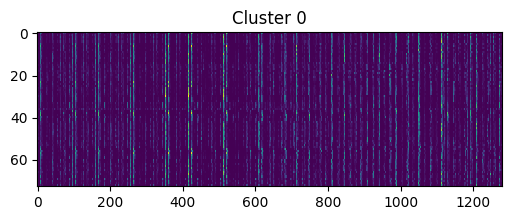

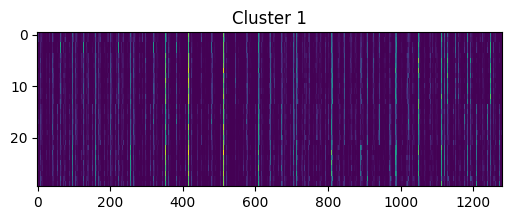

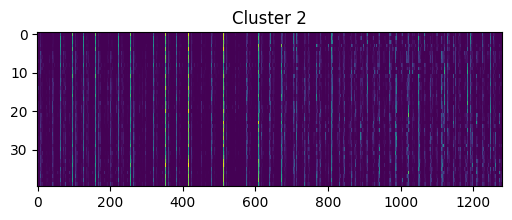

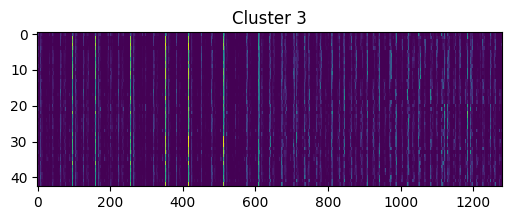

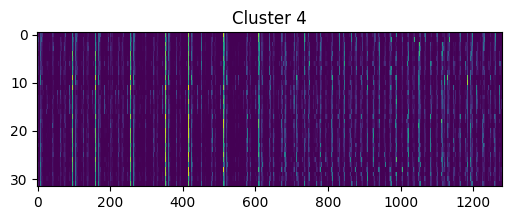

In [88]:
for c, cluster in enumerate(np.unique(final_clusters)):
    indices = np.where(final_clusters==cluster)[0]
    data = np.array(full_session_syllables[np.arange(0,np.shape(final_matrix)[1], 1)])[indices, :]
    plt.figure(figsize=(6, 2))
    plt.imshow(data, aspect='auto', cmap='viridis', interpolation='none')
    # plt.xticks(np.arange(0, np.shape(final_matrix)[1], 160), np.arange(0, np.shape(final_matrix)[1], 160))
    plt.title('Cluster ' + str(c))
    plt.show()